# Cel-Seq2

CEL-Seq2 is an enhanced version of the CEL-Seq (Cell Expression by Linear amplification and Sequencing) protocol for single-cell RNA sequencing, as described in this [paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0938-8). 

The example datasets we used are from [SRR7588583](https://trace.ncbi.nlm.nih.gov/Traces/?view=run_browser&acc=SRR7588583&display=metadata), a widely used datasets in [benchmarking](https://pubmed.ncbi.nlm.nih.gov/31133762/).

## SeqSpec

![celseq2](../assets/figure/celseq2.png)

Based on this library structure, we designate RA5 as the primer for read1 and RA3 as the primer for read2. It's important to note that both RA5 and RA3 should have their region_type set to custom_primer since they are non-standard primers rather than typical sequencing primers. This custom designation ensures proper handling of these unique primer sequences in the analysis pipeline.

```yaml
sequence_spec:
- !Read
  read_id: R1
  name: Read 1
  modality: rna
  primer_id: RA5
  min_len: 1
  max_len: 250
  strand: pos
  files: []
- !Read
  read_id: R2
  name: Read 2
  modality: rna
  primer_id: RA3
  min_len: 1
  max_len: 250
  strand: neg
  files: []
```

Another thing we should note is that the cell barcode whitelist of CelSeq2 study is various. In this experiment, we used barcodes downloaded [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE118767).

## Precellar pipeline

In [1]:
import precellar
precellar.__version__

'0.3.0-dev0'

In [5]:
assay = precellar.Assay("seqspec_template/cel_seq2.yaml")

In [6]:
assay

CEL-Seq2
└── rna(132-326)
    ├── illumina_p5(29)
    ├── RA5(26) [↓R1(1-250)✗]
    ├── umi(6)
    ├── cell_bc(8)
    ├── poly_T(30-98)
    ├── cDNA(1-98)
    ├── RA3(21) [↑R2(1-250)✗]
    ├── link_1(12)
    ├── sample_bc(6)
    └── illumina_p7(24)

Let look at our fastq dataset to check whether it satisfy this seqspec.

In [ ]:
! zcat /data2/litian/precellar_data/PalateCEL/SRR7588583_1.fastq.gz | head

```
@SRR7588583.1 1 length=32
AGAACNGCTCTGAANNNNNNNNNNNNNNNNNN
+SRR7588583.1 1 length=32
AAAAA#EEEEEEEE##################
@SRR7588583.2 2 length=32
GAGCGNAGTATCNNNNNNNNNNNNNNNNNNNN
+SRR7588583.2 2 length=32
AAAAA#EEEEAE####################
@SRR7588583.3 3 length=32
CGCCTNCCTTCTTNNNNNNNNNNNNNNNNNNN
```

In [ ]:
! zcat  /data2/litian/precellar_data/PalateCEL/SRR7588583_2.fastq.gz | head

```
@SRR7588583.1 1 length=71
NGGGGGGGGGGNGGGGGGGGGGGGGGGNGGGGGGNGGGGGGNGNNGGGGGGGGGGGGGGGGGNGGGGGGGG
+SRR7588583.1 1 length=71
#AAAAAEEEEE#EEEEE<EEEEEEEEE#AEEEEE#EEEEEE#E##<EEE<EEEE/EAEEE/<#EEEEEAEE
@SRR7588583.2 2 length=71
NTGGGTAGTGGNGAAGGACCGATATCAGAAAAATNCCTTCANGNNTACTAATTTATTAATAANCATTAGGT
+SRR7588583.2 2 length=71
#AAA/EEAEAE#EEEEEEEEE6EEEA<AEEE/EE#EEEEEA#/##EEEEEEEEE<EEAEEAE#A<EEA<AA
@SRR7588583.3 3 length=72
NACCCCTTCTGNCCCCTAGTAAGCCCAGTTGCTGNATCTGANCNNTTTGAGCTCTTTTTGTANTATACTCTA
```

In read1, we observe a 14bp 'N' region following the 6bp UMI and 8bp barcode sequences. This is a specific characteristic of this dataset. To handle this, we set both min_len and max_len parameters of read1 to 14 to trim off the 'N' region.

In [8]:
assay.update_read('R1', fastq='/data2/litian/precellar_data/PalateCEL/SRR7588583_1.fastq.gz',max_len=14,min_len = 14)
assay.update_read('R2', fastq='/data2/litian/precellar_data/PalateCEL/SRR7588583_2.fastq.gz',min_len=20,max_len=70)

[2025-02-20T14:05:45Z INFO] Treating /data/litian/202502_precellar/data/barcode/CelSeq2_GSE117617_barcode.txt as local file
[2025-02-20T14:05:45Z WARN] Read 'R1' has low percentage of matched records for region 'cell_bc'. Percentage of matched records: 46.50%


In [9]:
star = precellar.aligners.STAR("/data/Public/STAR_reference/refdata-gex-GRCh38-2024-A/star/") 

In [10]:
precellar.align(
    assay,
    modality='rna',
    aligner=star,
    output='20250220_celseq2_gene_matrix.h5ad',
    output_type='gene_quantification',
    num_threads=32,
)

[2025-02-20T14:06:01Z INFO] Starting alignment process
[2025-02-20T14:06:01Z INFO] Using provided Assay object
[2025-02-20T14:06:01Z INFO] Using modality: RNA
[2025-02-20T14:06:01Z INFO] Initialized aligner: STAR
[2025-02-20T14:06:02Z INFO] Initializing FastqProcessor with 32 threads and chunk size 10000000
[2025-02-20T14:06:02Z INFO] Adding mitochondrial DNA references: ["chrM", "M"]
[2025-02-20T14:06:02Z INFO] Generating alignments
[2025-02-20T14:06:02Z INFO] Using STAR aligner
[2025-02-20T14:06:02Z INFO] Counting barcodes...
[2025-02-20T14:06:02Z INFO] Treating /data/litian/202502_precellar/data/barcode/CelSeq2_GSE117617_barcode.txt as local file
[2025-02-20T14:06:33Z INFO] Aligning 68987831 reads...
[2025-02-20T14:06:33Z INFO] Processing output type: gene_quantification
[2025-02-20T14:06:33Z INFO] Starting gene quantification
100%|██████████| 68987831/68987831 [04:51<00:00, 237060.47it/s][2025-02-20T14:11:56Z INFO] Completed gene quantification, writing to: "20250220_celseq2_gene_m

{'frac_transcriptome': 0.5676187442391109,
 'sequenced_reads': 68987831.0,
 'frac_q30_bases_read2': 0.7711844695732999,
 'frac_mitochondrial': 0.23238289177544943,
 'frac_duplicates': 0.6476864987591802,
 'frac_confidently_mapped': 0.7187557321625929,
 'frac_q30_bases_barcode': 0.896682909193072,
 'frac_unmapped': 0.14783096050353617,
 'frac_valid_barcode': 0.8366271292106574,
 'sequenced_read_pairs': 0.0}

## Downstream analysis

In [12]:
import scanpy as sc
import hdf5plugin # we have to import this package to read h5ad file

In [24]:
anndata = sc.read_h5ad("20250220_celseq2_gene_matrix.h5ad")

In [25]:
anndata

AnnData object with n_obs × n_vars = 383 × 38606
    obs: 'exon_count', 'intron_count', 'mitochondrial_count'
    var: 'gene_name'

In [26]:
sc.pp.recipe_zheng17(anndata)

In [27]:
sc.pp.neighbors(anndata)
sc.tl.umap(anndata)

/data/litian/micromamba/envs/py311/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 999 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


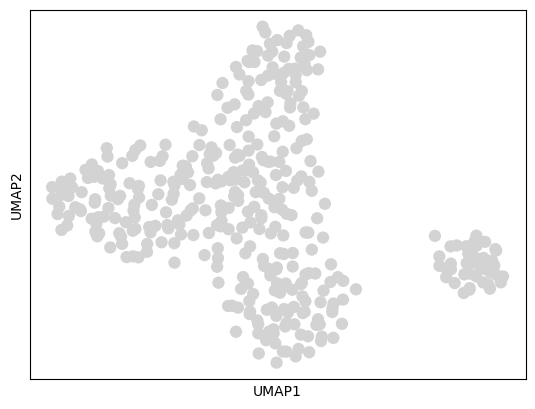

In [28]:
sc.pl.umap(anndata)